Import necessary packages:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

# seaborn is a nice package for plotting, but you have to use pip to install
import seaborn as sns

from sklearn import neighbors
from sklearn import cross_validation
from sklearn import metrics

Load in the Wisconsin breast cancer dataset. The attributes below will be
the columns of the dataset.

Attribute Information: (class attribute has been moved to last column)

      Attribute                     Domain
   -- -----------------------------------------
   1. Sample code number            id number
   2. Clump Thickness               1 - 10
   3. Uniformity of Cell Size       1 - 10
   4. Uniformity of Cell Shape      1 - 10
   5. Marginal Adhesion             1 - 10
   6. Single Epithelial Cell Size   1 - 10
   7. Bare Nuclei                   1 - 10
   8. Bland Chromatin               1 - 10
   9. Normal Nucleoli               1 - 10
  10. Mitoses                       1 - 10
  11. Class:                        (2 for benign, 4 for malignant)

The column names are taken from the dataset info file. Create an array
with the column names and assign them as the header when loading the
csv.

In [4]:
column_names = ['id',
                'clump_thickness',
                'cell_size_uniformity',
                'cell_shape_uniformity',
                'marginal_adhesion',
                'single_epithelial_size',
                'bare_nuclei',
                'bland_chromatin',
                'normal_nucleoli',
                'mitoses',
                'class']

bcw = pd.read_csv('../../assets/datasets/breast-cancer-wisconsin.csv',
                 names=column_names, index_col="id")


See what the unique values are of the non-id columns are with np.unique()

In [5]:
bcw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 699 entries, 1000025 to 897471
Data columns (total 10 columns):
clump_thickness           699 non-null int64
cell_size_uniformity      699 non-null int64
cell_shape_uniformity     699 non-null int64
marginal_adhesion         699 non-null int64
single_epithelial_size    699 non-null int64
bare_nuclei               699 non-null object
bland_chromatin           699 non-null int64
normal_nucleoli           699 non-null int64
mitoses                   699 non-null int64
class                     699 non-null int64
dtypes: int64(9), object(1)
memory usage: 60.1+ KB


In [6]:
bcw["bare_nuclei"].value_counts()

1     402
10    132
5      30
2      30
3      28
8      21
4      19
?      16
9       9
7       8
6       4
Name: bare_nuclei, dtype: int64

We can see that there are '?' fields in column 6 that are making some columns strings. Reload the dataset specifying na_values.

In [37]:
# bcw["bare_nuclei"] = pd.to_numeric(bcw["bare_nuclei"], errors='coerce')

bcw = pd.read_csv('../../assets/datasets/breast-cancer-wisconsin.csv',
                 names=column_names, na_values=['?'], index_col="id")

In [38]:
bcw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 699 entries, 1000025 to 897471
Data columns (total 10 columns):
clump_thickness           699 non-null int64
cell_size_uniformity      699 non-null int64
cell_shape_uniformity     699 non-null int64
marginal_adhesion         699 non-null int64
single_epithelial_size    699 non-null int64
bare_nuclei               683 non-null float64
bland_chromatin           699 non-null int64
normal_nucleoli           699 non-null int64
mitoses                   699 non-null int64
class                     699 non-null int64
dtypes: float64(1), int64(9)
memory usage: 60.1 KB


Now drop the null values from the dataset.

In [39]:
bcw.dropna(inplace=True)
bcw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 1000025 to 897471
Data columns (total 10 columns):
clump_thickness           683 non-null int64
cell_size_uniformity      683 non-null int64
cell_shape_uniformity     683 non-null int64
marginal_adhesion         683 non-null int64
single_epithelial_size    683 non-null int64
bare_nuclei               683 non-null float64
bland_chromatin           683 non-null int64
normal_nucleoli           683 non-null int64
mitoses                   683 non-null int64
class                     683 non-null int64
dtypes: float64(1), int64(9)
memory usage: 58.7 KB


Look at the header of the data below.

In [40]:
print bcw['class'].value_counts()
bcw.head()

2    444
4    239
Name: class, dtype: int64


,clump_thickness,cell_size_uniformity,cell_shape_uniformity,marginal_adhesion,single_epithelial_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
id,,,,,,,,,,
1000025,5,1,1,1,2,1.0,3,1,1,2
1002945,5,4,4,5,7,10.0,3,2,1,2
1015425,3,1,1,1,2,2.0,3,1,1,2
1016277,6,8,8,1,3,4.0,3,7,1,2
1017023,4,1,1,3,2,1.0,3,1,1,2


The class field is coded as "2" for benign and "4" as malignant. 

Let's recode this to a binary variable for classification, with "1" as malign and "0" as benign.

In [41]:
bcw['class'] = bcw['class'] == 4
# bcw['class'] = bcw['class'].apply(lambda x: 1 if x == 4 else 0)
# bcw['class'] = (bcw['class'] == 4).astype(int)

It's very useful and recommended to look at the correlation matrix:

In [42]:
bcw.corr()

,clump_thickness,cell_size_uniformity,cell_shape_uniformity,marginal_adhesion,single_epithelial_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
clump_thickness,1.000000,0.642481,0.653470,0.487829,0.523596,0.593091,0.553742,0.534066,0.350957,0.714790
cell_size_uniformity,0.642481,1.000000,0.907228,0.706977,0.753544,0.691709,0.755559,0.719346,0.460755,0.820801
cell_shape_uniformity,0.653470,0.907228,1.000000,0.685948,0.722462,0.713878,0.735344,0.717963,0.441258,0.821891
marginal_adhesion,0.487829,0.706977,0.685948,1.000000,0.594548,0.670648,0.668567,0.603121,0.418898,0.706294
single_epithelial_size,0.523596,0.753544,0.722462,0.594548,1.000000,0.585716,0.618128,0.628926,0.480583,0.690958
bare_nuclei,0.593091,0.691709,0.713878,0.670648,0.585716,1.000000,0.680615,0.584280,0.339210,0.822696
bland_chromatin,0.553742,0.755559,0.735344,0.668567,0.618128,0.680615,1.000000,0.665602,0.346011,0.758228
normal_nucleoli,0.534066,0.719346,0.717963,0.603121,0.628926,0.584280,0.665602,1.000000,0.433757,0.718677
mitoses,0.350957,0.460755,0.441258,0.418898,0.480583,0.339210,0.346011,0.433757,1.000000,0.423448
class,0.714790,0.820801,0.821891,0.706294,0.690958,0.822696,0.758228,0.718677,0.423448,1.000000


Most of these predictors are highly correlated with the "class" variable. This is already an indication that our classifier is very likely to perform well.

We can plot out in detail how the classes distribute across the variables using the very useful pairplot() function from seaborn:

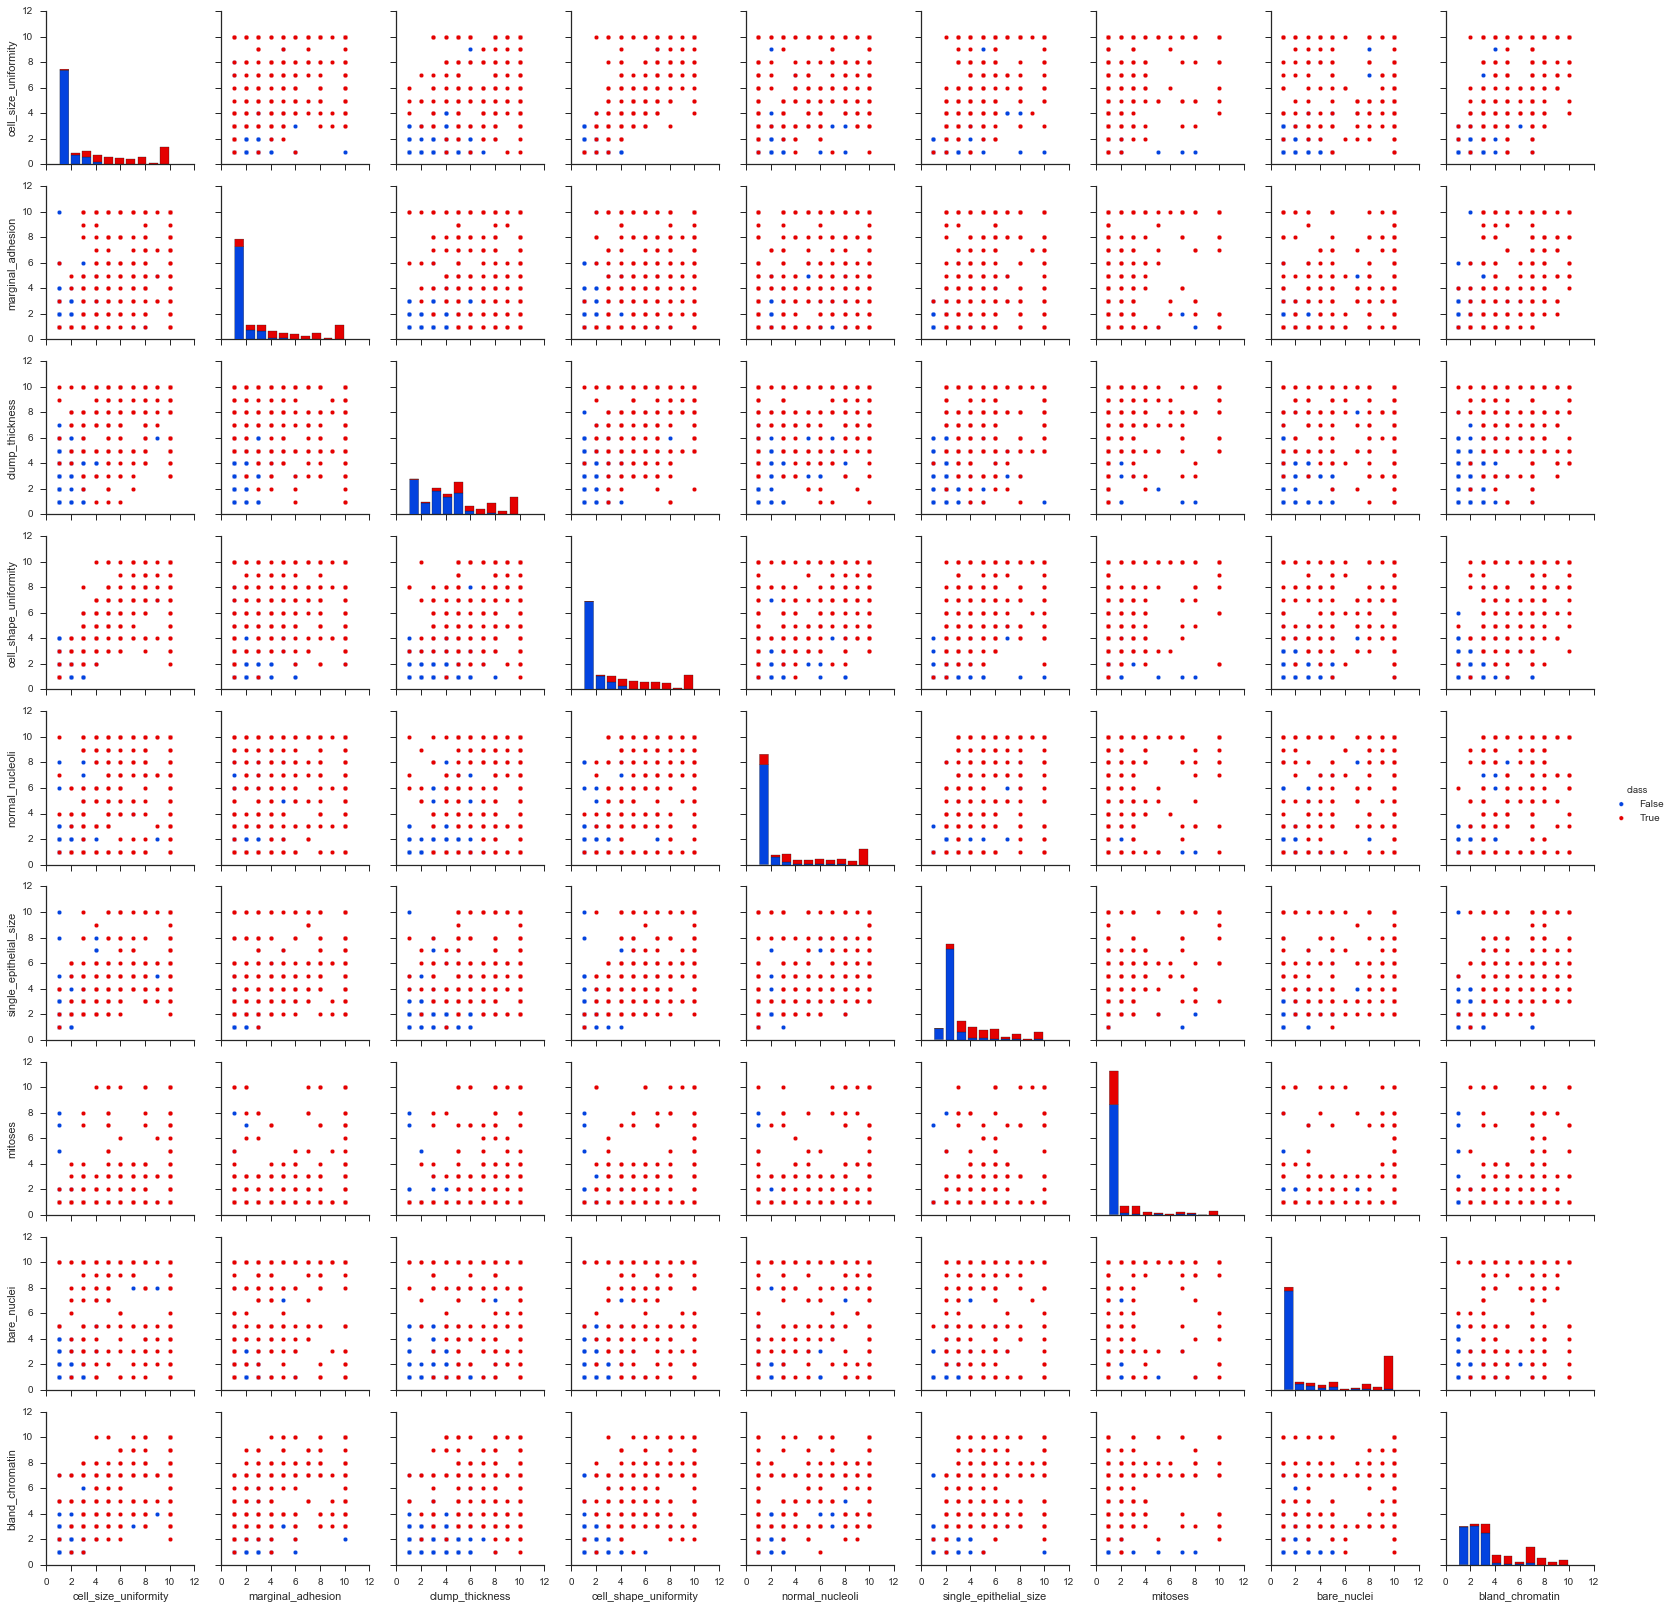

In [43]:
sns.set(style="ticks", color_codes=True)
var_pairs = sns.pairplot(bcw, hue="class", vars=set(bcw.columns)-set(["class"]),
                         palette=sns.xkcd_palette(['blue', 'red']))

Let's see how the kNN classifier performs on the dataset (using cross-validation).

We are going to set some parameters in the classifier constructor. Some clarification below:

1. **n_neighbors** specifies how many neighbors will vote on the class
2. **weights** uniform weights indicate that all neighbors have the same weight
3. **metric** and **p** when distance is minkowski (the default) and p == 2 (the default), this is equivalent to the euclidean distance metric

Also load scikit's handy cross-validation module and perform the crossval

In [45]:
features = list(set(bcw.columns) - set(['class']))
# features = [feat for feat in bcw.columns if feat not in ['class']]

y = bcw['class']
X = bcw[features]

In [46]:
cv = cross_validation.StratifiedKFold(y, n_folds=5)

In [47]:
knn = neighbors.KNeighborsClassifier(n_neighbors=3)

In [48]:
cross_validation.cross_val_score(knn, X=X, y=y, cv=cv)

array([ 0.93430657,  0.94890511,  0.98540146,  0.98540146,  0.97777778])

In [50]:
y_pred = cross_validation.cross_val_predict(knn, X=X, y=y, cv=cv)
print metrics.accuracy_score(y_true=y, y_pred=y_pred)
print metrics.confusion_matrix(y_true=y, y_pred=y_pred)

0.966325036603
[[433  11]
 [ 12 227]]


In [76]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, train_size=0.5)

In [79]:
def eval_knn(n_neighbors, X_train, X_test, y_train, y_test):

    knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)
    test_acc = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    # print "Accuracy on test  {0:.4f}".format(test_acc)
    y_pred = knn.predict(X_train)
    train_acc = metrics.accuracy_score(y_true=y_train, y_pred=y_pred)
    # print "Accuracy on train {0:.4f}".format(metrics.accuracy_score(y_true=y_train, y_pred=y_pred))
    return test_acc, train_acc

In [80]:
eval_knn(1, X_train, X_test, y_train, y_test)

(0.96198830409356728, 1.0)

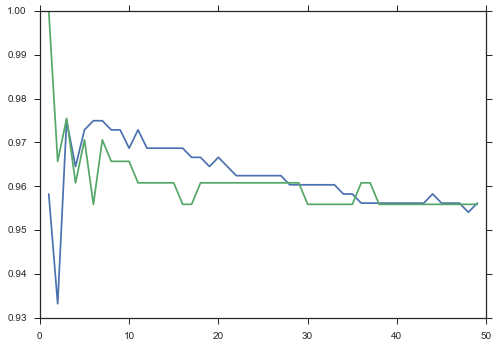

In [89]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, train_size=0.3)
i_range = list(range(1, 50))
acc = [eval_knn(i, X_train, X_test, y_train, y_test) for i in i_range]

train_acc, test_acc = zip(*acc)
plt.plot(i_range, train_acc)
plt.plot(i_range, test_acc)
plt.show()

In [93]:
print metrics.classification_report(y_true=y, y_pred=y_pred, target_names=['benign', 'malign'])

             precision    recall  f1-score   support

     benign       0.97      0.98      0.97       444
     malign       0.95      0.95      0.95       239

avg / total       0.97      0.97      0.97       683



Even with 1 neighbor we do quite well at predicting the malignant observations.

Now fit a kNN classifier with n_neighbors=5 using just 'clump thickness' and 'cell size uniformity' as variables.

Plot the points and the colors of where the classifier decides between malignant vs. benign. The size of the circles denotes the number of observations at that point. The hue of the circle denotes the mixture of class labels between 0 and 1.

In [90]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.cm as cm
import matplotlib.colors as cl

# reset the colors according to the outcome:
colors = sns.xkcd_palette(['blue', 'red'])
colormap = ListedColormap([colors[0], colors[1]])
cont_cmap = LinearSegmentedColormap.from_list('cont_cmap', colors = [colors[0], colors[1]], N = 1000)

In [91]:
def knn_graph(n_neighbors = 3,               
              x_column_1 = "clump_thickness", 
              x_column_2 = "cell_size_uniformity"):
    
    knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(y=y, X=bcw[[x_column_1, x_column_2]])

    x1 = bcw[x_column_1]
    x2 = bcw[x_column_2]

    x1_min, x1_max = x1.min()-1, x1.max()+1
    x2_min, x2_max = x2.min()-1, x2.max()+1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.2), np.arange(x2_min, x2_max, 0.2))
    mash_pred = knn.predict(zip(xx1.ravel(), xx2.ravel()))
    mash_pred = mash_pred.reshape(xx1.shape)
    plt.figure(figsize=[10,8])
    plt.pcolormesh(xx1, xx2, mash_pred, cmap=colormap, alpha=0.1)

    x1 = x1 + np.random.normal(0.0, 0.1, len(x1))
    x2 = x2 + np.random.normal(0.0, 0.1, len(x2))

    plt.scatter(x1, x2, c=y.astype(int), cmap=cont_cmap, alpha=0.3)
    plt.xlim((x1_min, x1_max-0.2))
    plt.ylim((x2_min, x2_max-0.2))

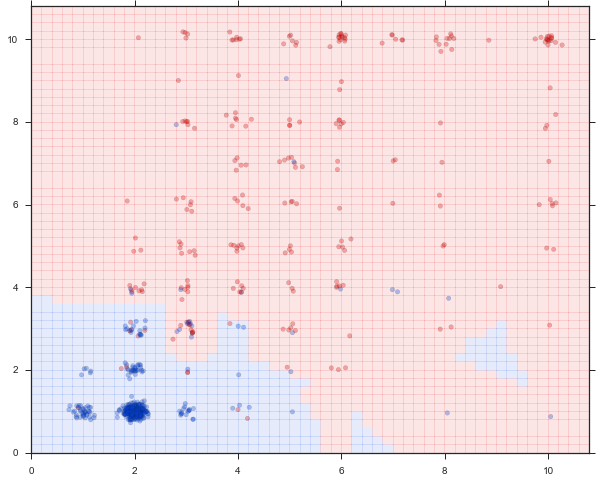

In [92]:
from ipywidgets.widgets import interact

    
interact(knn_graph, n_neighbors=(1, 30, 1), x_column_1=list(bcw.columns), x_column_2=list(bcw.columns))